
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [ ]:
!pip install d2l==1.0.0-beta0



# 数値安定性と初期化

:label: `sec_numerical_stability`

これまでに実装したすべてのモデルでは、事前に指定された分布に従ってパラメーターを初期化する必要がありました。これまで、私たちは初期化スキームを当然のこととして受け入れ、これらの選択がどのように行われるかについての詳細を説明していませんでした。これらの選択は特に重要ではないという印象さえ受けたかもしれません。それどころか、初期化スキームの選択はニューラル ネットワークの学習において重要な役割を果たし、数値の安定性を維持するために非常に重要です。さらに、これらの選択は、興味深い方法で非線形活性化関数の選択と結び付けることができます。どの関数を選択し、パラメーターをどのように初期化するかによって、最適化アルゴリズムがどれだけ早く収束するかが決まります。ここでの選択を誤ると、トレーニング中に勾配の爆発または消滅が発生する可能性があります。このセクションでは、これらのトピックをさらに詳しく掘り下げ、深層学習のキャリアを通じて役立ついくつかの有用なヒューリスティックについて説明します。


In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l


## グラデーションの消失と爆発

$L$ 層を持つ深いネットワークを考えます。入力 $\mathbf{x}$ と出力 $\mathbf{o}$ です。各層 $l$ は、重み $\mathbf{W}^{(l)}$ によってパラメータ化された変換 $f_l$ によって定義され、その隠れ層の出力は $\mathbf{h}^{(l)}$ になります (let $\mathbf{h}^{(0)} = \mathbf{x}$)、ネットワークは次のように表現できます。

 $$\mathbf{h}^{(l)} = f_l (\mathbf{h}^{(l-1)}) \text{ したがって、 } \mathbf{o} = f_L \circ \ldots \circ f_1 (\mathbf{x}).$$

すべての隠れ層の出力と入力がベクトルの場合、パラメータ $\mathbf{W}^{(l)}$ の任意のセットに関して $\mathbf{o}$ の勾配を次のように書くことができます。

 $$\partial_{\mathbf{W}^{(l)}} \mathbf{o} = \underbrace{\partial_{\mathbf{h}^{(L-1)}} \mathbf{h}^{ *(L)}} { \mathbf{M}^{(L)} \stackrel{\mathrm{def}}{=}} \cdot \ldots \cdot \underbrace{\partial {\mathbf{h}^{(* l)}} \mathbf{h}^ *{(l+1)}} { \mathbf{M}^{(l+1)} \stackrel{\mathrm{def}}{=}} \underbrace{\partial* {\mathbf{W}^{(l)}} \mathbf{h}^{(l)}}_{ \mathbf{v}^{(l)} \stackrel{\mathrm{def}}{=} }.$$

つまり、この勾配は $Ll$ 行列 $\mathbf{M}^{(L)} \cdot \ldots \cdot \mathbf{M}^{(l+1)}$ と勾配ベクトルの積です。 $\mathbf{v}^{(l)}$。したがって、あまりにも多くの確率を掛け合わせるとよく発生する数値アンダーフローと同じ問題が発生しやすくなります。確率を扱うときの一般的なトリックは、対数空間に切り替えることです。つまり、圧力を仮数から数値表現の指数に移すことです。残念ながら、上記の問題はさらに深刻です。最初、行列 $\mathbf{M}^{(l)}$ はさまざまな固有値を持つ可能性があります。それらは小さい場合もあれば大きい場合もあり、その製品は*非常に大きい*場合もあれば*非常に小さい場合*もあります。

不安定な勾配によってもたらされるリスクは、数値表現だけにとどまりません。予測できない大きさの勾配も、最適化アルゴリズムの安定性を脅かします。 (i) 過度に大きすぎてモデルが破壊される (*勾配爆発の*問題)。または、(ii) 小さすぎる場合 (*勾配消失*問題)、パラメータが更新のたびにほとんど動かないため、学習が不可能になります。

###  (**消失グラデーション**)

勾配消失問題を引き起こすよくある原因の 1 つは、各層の線形演算の後に追加される活性化関数 $\sigma$ の選択です。歴史的には、シグモイド関数 $1/(1 + \exp(-x))$ (:numref: `sec_mlp`で紹介) が、しきい値関数に似ているため人気がありました。初期の人工ニューラル ネットワークは生物学的ニューロン ネットワークに触発されていたため、(生物学的ニューロンのように)*完全に*発火するか*まったく*発火しないニューロンのアイデアは魅力的に思えました。シグモイドを詳しく見て、なぜ勾配の消失が発生するのかを見てみましょう。


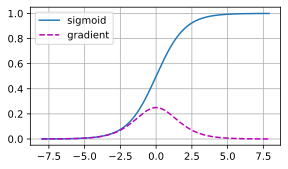

In [2]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

d2l.plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()],
         legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))


ご覧のとおり、(**シグモイドの勾配は、入力が大きい場合と小さい場合の両方で消失します**)。さらに、多くの層を逆伝播する場合、多くのシグモイドへの入力がゼロに近いゴルディロックス ゾーンにいない限り、積全体の勾配が消える可能性があります。ネットワークが多層である場合、注意しないと、どこかの層で勾配が途切れてしまう可能性があります。実際、この問題はディープ ネットワーク トレーニングを悩ませていました。その結果、より安定している (しかし神経的には妥当性が低い) ReLU が、実践者にとってのデフォルトの選択肢として浮上しました。

###  [**爆発するグラデーション**]

反対に、勾配が爆発的に増加する場合も同様に厄介な問題となる可能性があります。これをもう少しわかりやすく説明するために、100 個のガウスランダム行列を描画し、それらに初期行列を乗算します。私たちが選択したスケール (分散 $\sigma^2=1$ の選択) では、行列積は爆発します。深いネットワークの初期化によってこれが発生した場合、勾配降下オプティマイザーを収束させる機会はありません。


In [3]:
M = torch.normal(0, 1, size=(4, 4))
print('a single matrix \n',M)
for i in range(100):
    M = M @ torch.normal(0, 1, size=(4, 4))
print('after multiplying 100 matrices\n', M)

a single matrix 
 tensor([[ 0.0837, -0.9784, -0.5752, -0.0418],
        [ 2.0032,  2.0948, -1.4284, -1.5950],
        [-0.9720, -2.1672, -0.2809,  0.2282],
        [-0.7581,  0.0328, -0.2364, -0.5804]])
after multiplying 100 matrices
 tensor([[ 7.5119e+24, -9.2313e+24, -2.1761e+24,  7.0456e+23],
        [-1.3462e+24,  1.6544e+24,  3.8999e+23, -1.2627e+23],
        [ 1.4648e+25, -1.8001e+25, -4.2433e+24,  1.3739e+24],
        [ 8.9242e+24, -1.0967e+25, -2.5852e+24,  8.3702e+23]])



### 対称性の破壊

ニューラル ネットワーク設計におけるもう 1 つの問題は、パラメータ化に固有の対称性です。 1 つの隠れ層と 2 つのユニットを持つ単純な MLP があると仮定します。この場合、最初の層の重み $\mathbf{W}^{(1)}$ を並べ替え、同様に出力層の重みを並べ替えて、同じ関数を得ることができます。最初の隠しユニットと 2 番目の隠しユニットを区別する特別な点はありません。言い換えれば、各層の隠れユニット間には順列対称性があります。

これは単なる理論上の迷惑ではありません。前述の 2 つの隠れユニットを持つ 1 隠れ層 MLP を考えてみましょう。説明のために、出力層が 2 つの隠れユニットを 1 つの出力ユニットのみに変換すると仮定します。隠れ層のすべてのパラメーターを、ある定数 $c$ に対して $\mathbf{W}^{(1)} = c$ として初期化した場合に何が起こるかを想像してみてください。この場合、順伝播中に、いずれかの隠れユニットが同じ入力とパラメータを受け取り、同じアクティベーションを生成し、それが出力ユニットに供給されます。バックプロパゲーション中に、パラメータ $\mathbf{W}^{(1)}$ に関して出力ユニットを微分すると、要素がすべて同じ値を取る勾配が得られます。したがって、勾配ベースの反復 (ミニバッチ確率的勾配降下法など) の後でも、$\mathbf{W}^{(1)}$ のすべての要素は同じ値をとります。このような繰り返しでは、*対称性が自然に破られること*はなく、ネットワークの表現力を実現することは決してできないかもしれません。隠れ層は、ユニットが 1 つだけあるかのように動作します。ミニバッチの確率的勾配降下法ではこの対称性が破れませんが、ドロップアウト正則化 (後で紹介します) では対称性が破れることに注意してください。

## パラメータの初期化

上記の問題に対処する、または少なくとも軽減する方法の 1 つは、慎重に初期化することです。後で説明するように、最適化と適切な正規化の際にさらに注意を払うと、安定性がさらに向上します。

### デフォルトの初期化

前のセクション、たとえば :numref: `sec_linear_concise`では、正規分布を使用して重みの値を初期化しました。初期化方法を指定しない場合、フレームワークはデフォルトのランダム初期化方法を使用します。これは、多くの場合、中程度の問題サイズでは実際にうまく機能します。

### ザビエルの初期化

:label: `subsec_xavier`

*非線形性のない*完全結合層の出力 $o_{i}$ のスケール分布を見てみましょう。この層の $n_\mathrm{in}$ 入力 $x_j$ とそれに関連する重み $w_{ij}$ を使用すると、出力は次のようになります。

 $$o_{i} = \sum_{j=1}^{n_\mathrm{in}} w_{ij} x_j.$$

重み $w_{ij}$ はすべて、同じ分布から独立して描画されます。さらに、この分布の平均と分散がゼロ $\sigma^2$ であると仮定しましょう。これは、分布がガウス分布である必要があるという意味ではなく、平均と分散が存在する必要があるというだけであることに注意してください。ここでは、層 $x_j$ への入力も平均と分散 $\gamma^2$ がゼロであり、それらが $w_{ij}$ から独立しており、互いに独立していると仮定しましょう。この場合、$o_i$ の平均と分散は次のように計算できます。

 $$ \begin{aligned} E[o_i] &amp; = \sum_{j=1}^{n_\mathrm{in}} E[w_{ij} x_j] \&amp;= \sum_{j=1}^{n_ \mathrm{in}} E[w_{ij}] E[x_j] \&amp;= 0, \ \mathrm{Var}[o_i] &amp; = E[o_i^2] - (E[o_i])^2 \ &amp; = \sum_{j=1}^{n_\mathrm{in}} E[w^2_{ij} x^2_j] - 0 \ &amp; = \sum_{j=1}^{n_\mathrm{in}} E[w^2_{ij}] E[x^2_j] \ &amp; = n_\mathrm{in} \sigma^2 \gamma^2。 \end{整列} $$

分散を固定に保つ 1 つの方法は、 $n_\mathrm{in} \sigma^2 = 1$ を設定することです。次にバックプロパゲーションを考えてみましょう。そこでは、出力に近いレイヤーから勾配が伝播されるにもかかわらず、同様の問題に直面します。順伝播の場合と同じ推論を使用すると、$n_\mathrm{out} \sigma^2 = 1$ にならない限り、勾配の分散が爆発する可能性があることがわかります。ここで、$n_\mathrm{out}$ は次の出力の数です。この層。このため、両方の条件を同時に満たすことは不可能であるというジレンマに陥ることになります。代わりに、単に次の条件を満たすように努めます。

 $$ \begin{aligned} \frac{1}{2} (n_\mathrm{in} + n_\mathrm{out}) \sigma^2 = 1 \text{ または同等の値 } \sigma = \sqrt{\frac {2}{n_\mathrm{in} + n_\mathrm{out}}}。 \end{整列} $$

これは、現在標準となっており、実際に有益な*Xavier 初期化の*基礎となる推論です。Xavier 初期化の名前は、その作成者の最初の作成者の名前にちなんで付けられています (引用: `Glorot.Bengio.2010` )。通常、ザビエルの初期化では、平均と分散がゼロのガウス分布 $\sigma^2 = \frac{2}{n_\mathrm{in} + n_\mathrm{out}}$ から重みをサンプリングします。これを適応させて、一様分布から重みをサンプリングするときに分散を選択することもできます。一様分布 $U(-a, a)$ には分散 $\frac{a^2}{3}$ があることに注意してください。 $\frac{a^2}{3}$ を $\sigma^2$ の条件に代入すると、次に従って初期化するという提案が得られます。

 $$U\left(-\sqrt{\frac{6}{n_\mathrm{in} + n_\mathrm{out}}}, \sqrt{\frac{6}{n_\mathrm{in} + n_\ mathrm{out}}}\right).$$

上記の数学的推論における非線形性が存在しないという仮定は、ニューラル ネットワークでは簡単に破られる可能性がありますが、ザビエルの初期化方法は実際にはうまく機能することが判明しています。

### 下

上記の推論は、パラメータ初期化に対する最新のアプローチのほんの表面をなぞっただけです。深層学習フレームワークでは、多くの場合、十数種類の異なるヒューリスティックが実装されています。さらに、パラメーターの初期化は、引き続き深層学習の基礎研究で注目を集めている分野です。これらの中には、関連付けられた (共有) パラメーター、超解像度、シーケンス モデル、その他の状況に特化したヒューリスティックがあります。たとえば、:citet: `Xiao.Bahri.Sohl-Dickstein.ea.2018`慎重に設計された初期化方法を使用することで、アーキテクチャ上のトリックなしで 10,000 層のニューラル ネットワークをトレーニングできる可能性を実証しました。

トピックに興味がある場合は、このモジュールの内容を深く掘り下げ、各ヒューリスティックを提案および分析した論文を読んでから、そのトピックに関する最新の出版物を調べることをお勧めします。おそらく、賢いアイデアを見つけたり、発明したりして、深層学習フレームワークの実装に貢献することになるでしょう。

## まとめ

勾配の消失と爆発は、深層ネットワークでよく発生する問題です。勾配とパラメータを適切に制御できるようにするには、パラメータの初期化に細心の注意を払う必要があります。初期化ヒューリスティックは、初期勾配が大きすぎたり小さすぎたりしないようにするために必要です。ランダムな初期化は、最適化の前に対称性を確実に破るための鍵となります。 Xavier の初期化は、各層の出力の分散は入力数の影響を受けず、勾配の分散も出力数の影響を受けないことを示唆しています。 ReLU 活性化関数は、勾配消失の問題を軽減します。これにより、収束を加速できます。

## 演習
1. MLP の層における順列対称性以外に、ニューラル ネットワークが対称性の破れを示す可能性がある他のケースを設計できますか?
1. 線形回帰またはソフトマックス回帰のすべての重みパラメータを同じ値に初期化できますか?
1.  2 つの行列の積の固有値の解析限界を調べます。これは、勾配が適切に調整されていることを保証することについて何を意味しますか?
1. 一部の用語が異なることがわかった場合、事後的にこれを修正できるでしょうか?インスピレーションを得るためには、層ごとの適応レート スケーリングに関する論文を参照してください:cite: `You.Gitman.Ginsburg.2017` 。



[ディスカッション](https://discuss.d2l.ai/t/104)
